In [ ]:
import numpy as np

In [ ]:

## writing from the scractch

In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
label_csv= pd.read_csv("/content/drive/MyDrive/Dog_Vision/labels.csv")
label_csv
from IPython.display import Image

filenames= ["/content/drive/MyDrive/Dog_Vision/train/" + val +".jpg" for val in label_csv["id"]]
Image(filenames[1])
#going to get the target set
labels= label_csv.breed.to_numpy()
unique_labels= np.unique(labels)
boolean_labels= [ val==np.array(unique_labels) for val in labels]
#we have created labels now we want to convert them tensor so that it can work with the tensor flow
# a function to process the image in tensor
IMG_SIZE=224
def process_image(image_path,img_size=224):
  image= tf.io.read_file(image_path)
  image= tf.image.decode_jpeg(image,channels=3)
  #normalize it
  image=tf.image.convert_image_dtype(image,tf.float32)
  image=tf.image.resize(image,size=[224,224])
  return image
#lets give tuple of tensor of image and labels;
def set_image_label(image_path,label):
  image=process_image(image_path)

  return image,label

In [4]:
from ast import Num
#creating number of samples to take for training
Num_samples=1000 #@param {type:"slider",min:1000,max:10000,step:1000}


In [5]:
x=filenames
y=boolean_labels

In [6]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x[:Num_samples],y[:Num_samples],test_size=0.2,random_state=42)

In [7]:
#lets get the image in batches to feed the model

## Batches to create for Model

In [8]:
BATCH_SIZE=32

def create_batches(x,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):

  #we have to create batches for every condition
  #for train,test,validate ,so lets begin
  #if data is test_data we dont want to add labels or shuffle it

  if test_data:
    print("creatin the test_batches")
    data= tf.data.Dataset.from_tensor_slices(tf.constant(x))
    data_batch= data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  #validation set creations , we dont need to  shuffle
  elif valid_data:

    print("creataing the validation set")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
    data_batch= data.map(set_image_label).batch(BATCH_SIZE)
    return data_batch

  #creating the trainging data and we need to shuffle it
  else:
    print("crearting the training data")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
    data=data.shuffle(buffer_size=len(x))
    data_batch= data.map(set_image_label).batch(BATCH_SIZE)
    return data_batch


In [9]:
train_data=create_batches(x_train,y_train)
val_data=create_batches(x_val,y_val,valid_data=True)

crearting the training data
creataing the validation set


In [10]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [11]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:
import seaborn as sb

## Lets visualize the data

In [ ]:

def visualize_25_image(images,labels):
  #using matplotlib , we will  use that
  fig= plt.figure(figsize=(10,10))

  for i in range(25):

    ax= plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.axis("off")
    plt.title(unique_labels[labels[i].argmax()])



In [ ]:
train_images,train_labels=next(train_data.as_numpy_iterator())

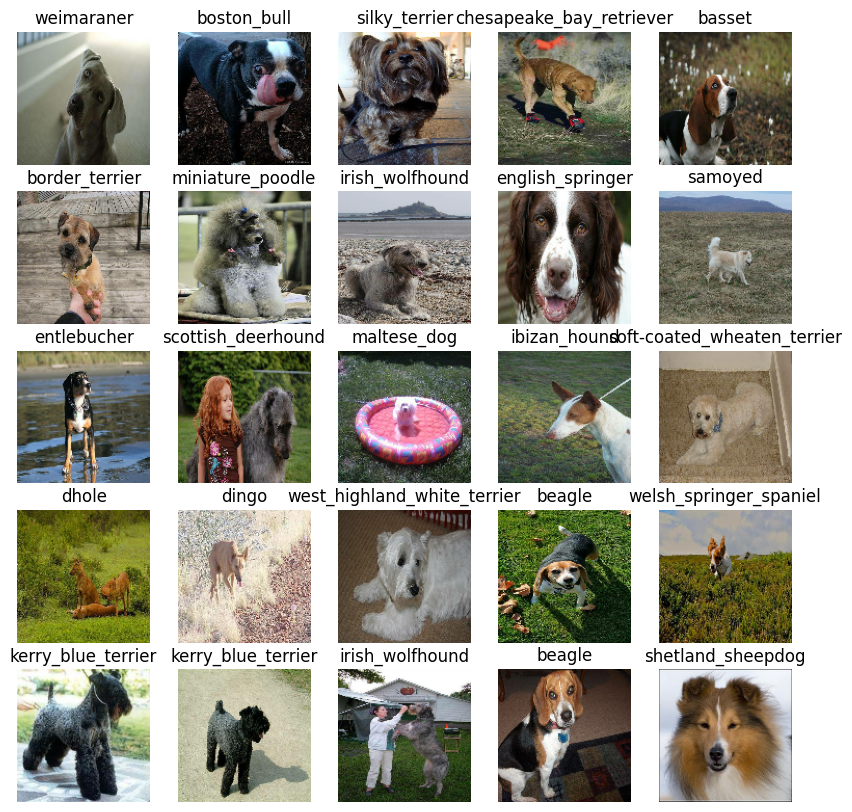

In [ ]:
visualize_25_image(train_images,train_labels)

In [12]:

#lets give and difine the model
import tf_keras as keras
INPUT_SIZE=[None,IMG_SIZE,IMG_SIZE,3]
# "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-128-classification/2"
OUTPUT_SIZE=len(unique_labels)
MODEL_URL="https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [13]:
def creating_model(input_shape=INPUT_SIZE,output_shape=OUTPUT_SIZE,model_url=MODEL_URL):
  print("creating the model")
  model= keras.Sequential([
      hub.KerasLayer(MODEL_URL),
      keras.layers.Dense(units=OUTPUT_SIZE,activation="softmax")
  ])
  model.compile(
      loss= keras.losses.CategoricalCrossentropy(),
      optimizer=keras.optimizers.Adam(),
      metrics=["accuracy"]
  )
  model.build(INPUT_SIZE)
  return model



In [ ]:
model= creating_model()

creating the model


In [14]:
#lets now create the tensortable for callback and monitor of model and early stopping

%load_ext tensorboard


In [15]:
import datetime
import os
def  tesnor_board_callback():
  logdir= os.path.join("/content/drive/MyDrive/Dog_Vision/logs",
                       datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

                       )
  return keras.callbacks.TensorBoard(logdir)

early_stopage= keras.callbacks.EarlyStopping(monitor="val_loss",patience=3)

In [16]:
#lets create the Model
NUM_EPOCHS=100 #@param {type:"slider",min:10,max:100,step:10}

In [ ]:

def training_model():
  print("creating the model")
  model=creating_model()
  tensorboard=tesnor_board_callback()
  model.fit(
      x=train_data,
      validation_data=val_data,
      epochs=NUM_EPOCHS,
      validation_freq=1,
      callbacks=[tensorboard,early_stopage]
  )
  return model

In [ ]:
model= training_model()

creating the model
creating the model
Epoch 1/100
25/25 [==============================] - 7s 127ms/step - loss: 5.7210 - accuracy: 0.0388 - val_loss: 4.6123 - val_accuracy: 0.0850
Epoch 2/100
25/25 [==============================] - 4s 164ms/step - loss: 2.4498 - accuracy: 0.4125 - val_loss: 3.7004 - val_accuracy: 0.2000
Epoch 3/100
25/25 [==============================] - 3s 119ms/step - loss: 1.0944 - accuracy: 0.7775 - val_loss: 3.4518 - val_accuracy: 0.2700
Epoch 4/100
25/25 [==============================] - 3s 116ms/step - loss: 0.5152 - accuracy: 0.9488 - val_loss: 3.3740 - val_accuracy: 0.2700
Epoch 5/100
25/25 [==============================] - 3s 118ms/step - loss: 0.2711 - accuracy: 0.9912 - val_loss: 3.4057 - val_accuracy: 0.2700
Epoch 6/100
25/25 [==============================] - 4s 169ms/step - loss: 0.1677 - accuracy: 1.0000 - val_loss: 3.4502 - val_accuracy: 0.2800
Epoch 7/100
25/25 [==============================] - 3s 122ms/step - loss: 0.1168 - accuracy: 1.0000 - v

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/Dog_Vision/logs

In [ ]:
#start with the prediction,of



In [ ]:
prediction= model.predict(val_data, verbose=1)

7/7 [==============================] - 1s 101ms/step


In [ ]:
print(f"first row prediction {unique_labels[np.argmax(prediction[0])]}")

first row prediction border_terrier


In [19]:
#now lets create the function to do this
def  get_pred_labels(prediction_probabilites):
  return unique_labels[np.argmax(prediction_probabilites)]



In [17]:
#lets create function to unbatchify the valdata so that we can make predictions
def unbatchify(data):
  images=[]
  labels=[]
  for image,label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_labels[np.argmax(label)])
  return images,labels

val_images,val_labels= unbatchify(val_data)
type(val_images)

list

In [18]:
#lets create function to visualize it
def plot_pred(prediction_prob, images,labels,n=1):
  pred_prob,image,truth_label= prediction_prob[n],images[n],labels[n]
  pred_label= get_pred_labels(pred_prob)
  plt.imshow(image)
  if pred_label==truth_label:
    color="green"
  else:
    color="red"
  plt.xticks([])
  plt.yticks([])
  plt.title(f"pred:{pred_label} truth:{truth_label}, Probability :{np.max(pred_prob)*100:.2f}%",color=color)
  plt.show()

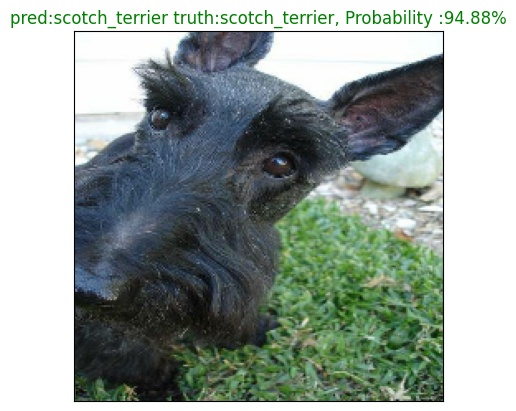

In [ ]:
plot_pred(prediction_prob=prediction,images=val_images,labels=val_labels,n=1)

In [20]:
def pred_prob_cnf(prediction_prob, labels,n=1):
  pred_prob,truth_label= prediction_prob[n],labels[n]
  pred_label= get_pred_labels(pred_prob)
  #findig top 10 predictions
  top_10_pred_indexes= pred_prob.argsort()[-10:][::-1]

  top_10_pred_labels= unique_labels[top_10_pred_indexes]
  top_10_pred_values= pred_prob[top_10_pred_indexes]
  #plotting
  top_plot=plt.bar(np.arange(len(top_10_pred_labels)),top_10_pred_values,color='grey')
  plt.xticks(np.arange(len(top_10_pred_labels)),top_10_pred_labels,rotation='vertical')

  if np.isin(truth_label,top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels==truth_label)].set_color("green")
  else:
    pass

  plt.title(f"pred:{pred_label} truth:{truth_label}")
  plt.show()




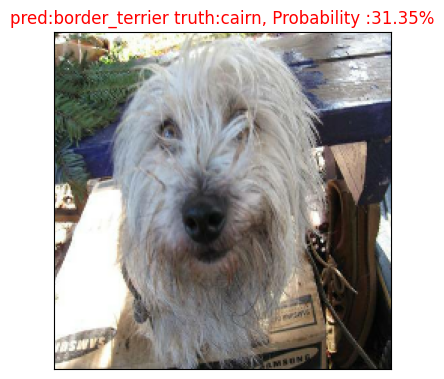

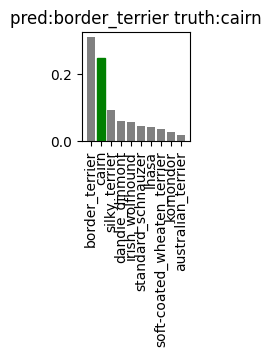

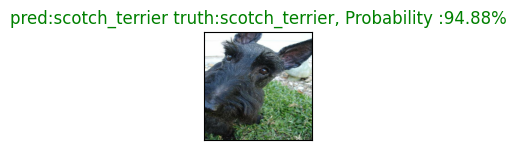

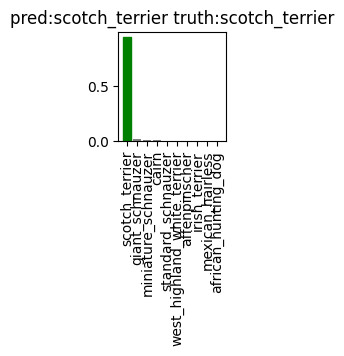

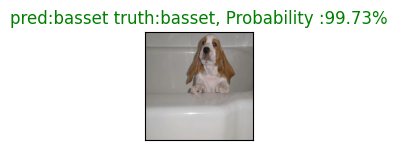

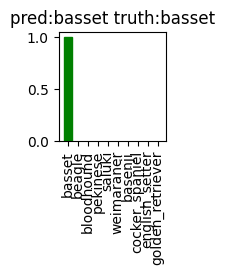

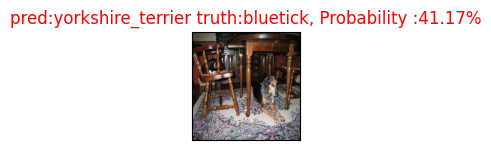

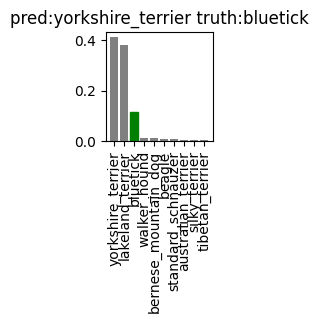

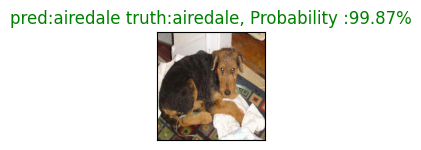

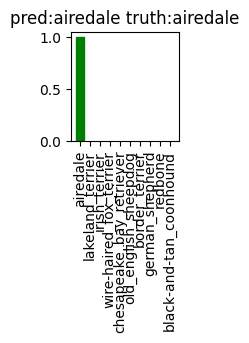

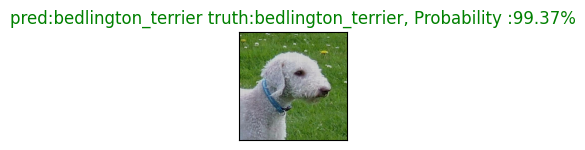

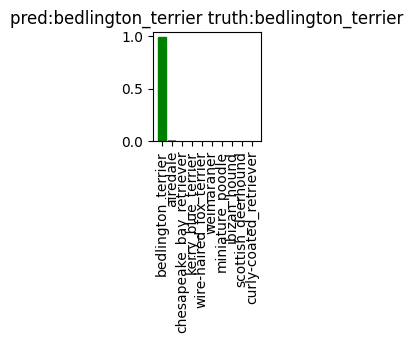

<Figure size 640x480 with 0 Axes>

In [ ]:
# Let's check a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_prob=prediction,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  pred_prob_cnf(prediction_prob=prediction,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

In [21]:

#lets save our model
def save_model(model,suffix=None):
  model_dir=os.path.join("/content/drive/MyDrive/Dog_Vision/models",
                         datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  model_path=model_dir+"_"+suffix+".h5"
  model.save(model_path)
  return model_path

In [22]:
def load_model(model_path):
  print(f"loading the saved model from {model_path}")
  model= keras.models.load_model(model_path,custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [23]:
save_model(model,suffix="1000_img_mobilenetv2")

NameError: name 'model' is not defined

In [ ]:
load_1000_img_model=load_model('/content/drive/MyDrive/Dog_Vision/models/20250726-081359_1000_img_mobilenetv2.h5')

loading the saved model from /content/drive/MyDrive/Dog_Vision/models/20250726-081359_1000_img_mobilenetv2.h5


In [ ]:
load_1000_img_model.evaluate(val_data)

7/7 [==============================] - 2s 119ms/step - loss: 1.1625 - accuracy: 0.6900


[1.162480354309082, 0.6899999976158142]

In [24]:
full_data= create_batches(x,y)

crearting the training data


In [25]:
full_model= creating_model()

creating the model


In [27]:
full_model_tensorboard= tesnor_board_callback()
full_model_early_stopping= keras.callbacks.EarlyStopping(monitor="accuracy",patience=3)

In [28]:
full_model.fit(x=full_data,epochs=NUM_EPOCHS,callbacks=[full_model_tensorboard,full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 1720s 5s/step - loss: 1.3406 - accuracy: 0.6705
Epoch 2/100
320/320 [==============================] - 37s 117ms/step - loss: 0.3994 - accuracy: 0.8824
Epoch 3/100
320/320 [==============================] - 37s 116ms/step - loss: 0.2393 - accuracy: 0.9334
Epoch 4/100
320/320 [==============================] - 37s 115ms/step - loss: 0.1540 - accuracy: 0.9633
Epoch 5/100
320/320 [==============================] - 37s 114ms/step - loss: 0.1048 - accuracy: 0.9789
Epoch 6/100
320/320 [==============================] - 35s 109ms/step - loss: 0.0775 - accuracy: 0.9862
Epoch 7/100
320/320 [==============================] - 37s 116ms/step - loss: 0.0595 - accuracy: 0.9913
Epoch 8/100
320/320 [==============================] - 38s 118ms/step - loss: 0.0467 - accuracy: 0.9937
Epoch 9/100
320/320 [==============================] - 37s 114ms/step - loss: 0.0380 - accuracy: 0.9958
Epoch 10/100
320/320 [==============================] - 36s 113ms

In [29]:
save_model(full_model,suffix="full_data_mobilenetv2")

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'/content/drive/MyDrive/Dog_Vision/models/20250726-102123_full_data_mobilenetv2.h5'

In [31]:
full_model= load_model("/content/drive/MyDrive/Dog_Vision/models/20250726-102123_full_data_mobilenetv2.h5")

loading the saved model from /content/drive/MyDrive/Dog_Vision/models/20250726-102123_full_data_mobilenetv2.h5


In [32]:
full_model.evaluate(val_data)

7/7 [==============================] - 2s 241ms/step - loss: 0.0070 - accuracy: 1.0000


[0.006961712148040533, 1.0]

## lets now Test on the dataset

In [42]:
test_path= "/content/drive/MyDrive/Dog_Vision/test/"
test_filenames=[test_path+ fname for fname in  os.listdir(test_path)]
test_filenames[:10]

['/content/drive/MyDrive/Dog_Vision/test/e6ed62f411426a4f7e26e6ccdbaf7ecc.jpg',
 '/content/drive/MyDrive/Dog_Vision/test/dd703c7beeaf5cba5533d5f42b608f2e.jpg',
 '/content/drive/MyDrive/Dog_Vision/test/e23ad195d88975333bbcde7dce5faf01.jpg',
 '/content/drive/MyDrive/Dog_Vision/test/e39be68f3200f0ecde589e571ae6df06.jpg',
 '/content/drive/MyDrive/Dog_Vision/test/e312dda8d35118c40880c0f331c09509.jpg',
 '/content/drive/MyDrive/Dog_Vision/test/e73dc6a8f2d7c941f28c0a5298bc5bdc.jpg',
 '/content/drive/MyDrive/Dog_Vision/test/e5de4eec61d00ee4834ff0153f90ed41.jpg',
 '/content/drive/MyDrive/Dog_Vision/test/dd026c42cfd91ea64b1fe5db04a18863.jpg',
 '/content/drive/MyDrive/Dog_Vision/test/e6926a5046cd957245918c33985bcd62.jpg',
 '/content/drive/MyDrive/Dog_Vision/test/df92d68c07ec91b2f67cec77980e00cf.jpg']

In [43]:
len(test_filenames)

10357

In [44]:
test_data= create_batches(test_filenames,test_data=True)

creatin the test_batches


In [45]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [46]:
#prediction
test_prediction= full_model.predict(test_data,verbose=1)

324/324 [==============================] - 240s 728ms/step


In [40]:
file_path = "/content/drive/MyDrive/Dog_Vision/teste6ed62f411426a4f7e26e6ccdbaf7ecc.jpg"
print("Exists:", os.path.exists(file_path))

Exists: False


In [47]:
np.savetxt("/content/drive/MyDrive/Dog_Vision/preds_array.csv",test_prediction,delimiter=",")

In [48]:
test_prediction= np.loadtxt("/content/drive/MyDrive/Dog_Vision/preds_array.csv",delimiter=",")

In [49]:
test_prediction[:10]

array([[5.73626313e-10, 1.96599139e-12, 1.22699800e-12, ...,
        2.74552395e-11, 2.12477475e-12, 1.66478014e-08],
       [6.92355964e-11, 2.07813201e-07, 2.75207579e-10, ...,
        3.99620141e-08, 1.36314679e-12, 6.58991958e-11],
       [1.14053356e-09, 4.79985740e-09, 2.67573095e-12, ...,
        3.47573671e-11, 1.64619998e-10, 1.01973117e-12],
       ...,
       [2.10773608e-12, 4.60694274e-08, 4.57774014e-08, ...,
        2.25016408e-10, 1.09536415e-08, 1.53316995e-11],
       [6.98344195e-07, 5.28672672e-06, 2.98266367e-09, ...,
        7.11330799e-08, 1.26486075e-05, 2.35880520e-06],
       [1.89999017e-10, 1.21105445e-10, 3.48699273e-14, ...,
        9.57002218e-14, 5.17771793e-14, 2.46279577e-11]])

In [50]:
test_prediction.shape

(10357, 120)

In [52]:
pred_df= pd.DataFrame(columns=["id"]+ list(unique_labels))

In [56]:
test_ids= [os.path.splitext(frame)[0] for frame in os.listdir(test_path)]

In [59]:
pred_df['id']= test_ids

In [60]:
pred_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e6ed62f411426a4f7e26e6ccdbaf7ecc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,dd703c7beeaf5cba5533d5f42b608f2e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e23ad195d88975333bbcde7dce5faf01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e39be68f3200f0ecde589e571ae6df06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e312dda8d35118c40880c0f331c09509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
pred_df[list(unique_labels)]=test_prediction

In [62]:
pred_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e6ed62f411426a4f7e26e6ccdbaf7ecc,5.736263e-10,1.965991e-12,1.226998e-12,1.035455e-09,1.115062e-07,1.292917e-11,1.867994e-11,5.048826e-12,5.831215e-12,...,4.702973e-08,8.675374e-11,2.302024e-10,4.891467e-11,5.294390e-10,1.018455e-10,1.084826e-11,2.745524e-11,2.124775e-12,1.664780e-08
1,dd703c7beeaf5cba5533d5f42b608f2e,6.923560e-11,2.078132e-07,2.752076e-10,4.894248e-09,5.468182e-09,3.625652e-10,1.198832e-12,1.131163e-11,1.769646e-10,...,1.785389e-12,1.001333e-11,1.350652e-11,6.171051e-11,8.037461e-11,2.361537e-12,1.044497e-13,3.996201e-08,1.363147e-12,6.589920e-11
2,e23ad195d88975333bbcde7dce5faf01,1.140534e-09,4.799857e-09,2.675731e-12,2.710736e-10,1.412592e-07,6.983424e-11,7.176184e-09,1.563191e-09,4.696113e-10,...,7.542911e-10,7.808755e-10,1.057665e-10,4.643434e-08,9.871461e-09,5.007794e-10,7.993664e-09,3.475737e-11,1.646200e-10,1.019731e-12
3,e39be68f3200f0ecde589e571ae6df06,2.473472e-08,1.672385e-11,1.130114e-09,7.117122e-13,1.023460e-11,6.956138e-10,2.327971e-10,7.863952e-11,4.442305e-12,...,3.131800e-08,6.515204e-08,4.624910e-11,9.011041e-12,7.193870e-11,3.105758e-11,2.734648e-09,2.055679e-12,3.908703e-08,3.321348e-06
4,e312dda8d35118c40880c0f331c09509,5.388113e-10,9.106081e-15,5.948201e-11,3.190020e-14,4.532467e-12,2.914200e-15,3.053333e-15,5.631662e-12,6.198602e-11,...,5.846271e-12,1.417246e-10,6.660440e-14,4.071322e-17,1.106404e-13,1.417630e-14,2.371184e-12,2.841146e-13,1.387780e-11,2.284415e-13


In [63]:
pred_df.to_csv("/content/drive/MyDrive/Dog_Vision/full_model_prediction_1_mobilenet.csv",index=False)